# Libraries

In [30]:
from matplotlib import pyplot as plt
import numpy as np

# Given function

In [31]:
def given_function(x):
    return np.exp(-4 * np.sin(x))

# Function plot

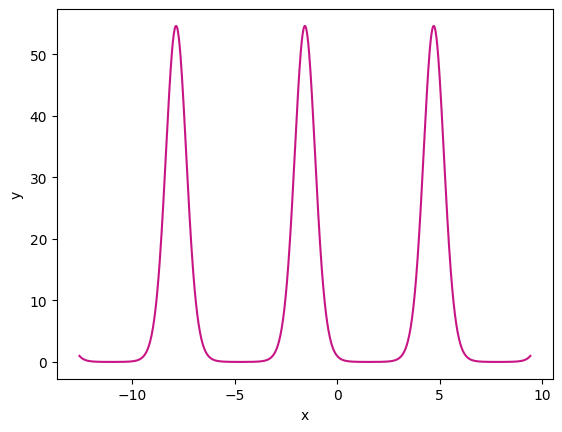

In [32]:
x = np.linspace(-4*np.pi, 3*np.pi, 1000)
y = np.exp(-4 * np.sin(x))

plt.plot(x, y, color='mediumvioletred')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

# Derivative

In [33]:
def derivative(f, x, acc, calc = True):
    if calc:
        return (-4*np.exp(-4 * np.sin(x))*np.cos(x))
    else:
        h = 2**(-acc)
        return (f(x + h) - f(x-h))/(2*h)

# Distribution

In [34]:
def even_distribution(a, b, n):
    return np.linspace(a, b, n)

# Quadratic spline

In [39]:
def polynomial_q(x_p, x, a, b, c):
    if x_p < x[0] or x_p > x[len(x) - 1]:
        return None
    i = 0
    for j in range(len(x) - 1):
        if x_p >= x[j] and x_p <= x[j + 1]:
            i = j
            break

    return a[i] + b[i] * (x_p - x[i]) + c[i] * (x_p - x[i]) ** 2


def natural_spline_q(gamma):
    Y_vec = np.array([0] + [2 * gamma[i] for i in range(len(gamma))])
    A_matrix = np.array(
        [([0 for i in range(j)] + [1, 1] + [0 for i in range(len(gamma) - 1 - j)]) for j in range(len(gamma))])
    A_matrix = np.concatenate(([[1] + [0 for i in range(len(gamma))]], A_matrix), axis=0)

    return Y_vec, A_matrix


def clamped_spline(gamma):
    Y_vec = np.array([gamma[0]] + [2 * gamma[i] for i in range(len(gamma))])
    A_matrix = np.array(
        [([0 for i in range(j)] + [1, 1] + [0 for i in range(len(gamma) - 1 - j)]) for j in range(len(gamma))])
    A_matrix = np.concatenate(([[1] + [0 for i in range(len(gamma))]], A_matrix), axis=0)

    return Y_vec, A_matrix


def quadratic_spline(x, y, xs, boundary_condition=1):
    # 1 -> natural
    # 2 -> clamped
    a = y
    gamma = [(y[i] - y[i - 1]) / (x[i] - x[i - 1]) for i in range(1, len(y))]

    if boundary_condition == 1:  # natural
        Y_vec, A_matrix = natural_spline_q(gamma)

    elif boundary_condition == 2:  # clamped
        Y_vec, A_matrix = clamped_spline(gamma)

    b = np.linalg.solve(A_matrix, Y_vec)
    c = []
    for i in range(len(b) - 1):
        c.append((b[i + 1] - b[i]) / (2 * (x[i + 1] - x[i])))

    result = []
    for point_x in xs:
        result.append(polynomial_q(point_x, x, a, b, c))

    return result

# Cubic spline

In [41]:
def polynomial_c(x_p, x, y, b, c, d):
    if x_p < x[0] or x_p > x[len(x) - 1]:
        return None
    i = 0
    for j in range(len(x) - 1):
        if x_p >= x[j] and x_p <= x[j + 1]:
            i = j
            break

    return y[i] + b[i] * (x_p - x[i]) + c[i] * (x_p - x[i]) ** 2 + d[i] * (x_p - x[i]) ** 3


def delta_1(p1, p2):
    return (p2[1] - p1[0]) / (p2[0] - p1[0])


def delta_2(p1, p2, p3):
    return (delta_1(p2, p3) - delta_1(p1, p2)) / (p2[0] - p1[0])


def delta_3(p1, p2, p3, p4):
    return (delta_2(p2, p3, p4) - delta_2(p1, p2, p3)) / (p3[0] - p1[0])


def natural_spline_c(x, y, h, Y_vec, A_matrix):
    x_len = len(x)
    y_len = len(y)
    h_len = len(h)
    delta_3_counted_1 = delta_3((x[0], y[0]), (x[1], y[1]), (x[2], y[2]), (x[3], y[3]))
    delta_3_counted_n = delta_3((x[x_len - 4], y[y_len - 4]), (x[x_len - 3], y[y_len - 3]),
                                (x[x_len - 2], y[y_len - 2]), (x[x_len - 1], y[y_len - 1]))

    y1 = h[0] ** 2 * delta_3_counted_1

    yn = -h[len(h) - 1] ** 2 * delta_3_counted_n

    Y_vec = np.concatenate(([y1], Y_vec, [yn]))
    A_matrix = np.concatenate(([[1] + [0 for _ in range(h_len)]],
                               A_matrix, [[0 for _ in range(h_len)] + [1]]), axis=0)

    return Y_vec, A_matrix


def cube_spline(h, Y_vec, A_matrix):
    len_h = len(h)
    A_matrix = np.concatenate(([[-h[0], h[0]] + [0 for _ in range(len_h - 1)]],
                               A_matrix, [[0 for _ in range(len_h - 1)] + [-h[len_h - 1], h[len_h - 1]]]),
                              axis=0)
    Y_vec = np.concatenate(([0], Y_vec, [0]))

    return Y_vec, A_matrix


def cubic_spline(x, y, xs, boundary_condition=1):
    # 1 -> natural
    # 2 -> cube
    x_len = len(x)
    y_len = len(y)
    h = [x[i + 1] - x[i] for i in range(x_len - 1)]
    delta = [(y[i + 1] - y[i]) / h[i] for i in range(x_len - 1)]
    Y_vec = np.array([delta[i + 1] - delta[i] for i in range(len(delta) - 1)])
    A_matrix = np.array(
        [([0 for i in range(j)] + [h[j], 2 * (h[j] + h[j + 1]), h[j + 1]] + [0 for i in range(len(h) - 2 - j)]) for j in
         range(len(h) - 1)])

    if boundary_condition == 2:
        Y_vec, A_matrix = natural_spline_c(x, y, h, Y_vec, A_matrix)

    elif boundary_condition == 1:
        Y_vec, A_matrix = cube_spline(h, Y_vec, A_matrix)

    sigma = np.linalg.solve(A_matrix, Y_vec)
    b = [(y[i + 1] - y[i]) / h[i] - h[i] * (sigma[i + 1] + 2 * sigma[i]) for i in range(x_len - 1)]
    c = [3 * sigma[i] for i in range(x_len - 1)]
    d = [(sigma[i + 1] - sigma[i]) / h[i] for i in range(x_len - 1)]

    result = []
    for point_x in xs:
        result.append(polynomial_c(point_x, x, y, b, c, d))

    return result


# Plot

In [37]:
def draw_plot(a, b, knot_nb, f, dist, inter, boundary_cond, draw):
    n1 = 500
    x_dist = dist(a, b, knot_nb)
    x_plot = np.linspace(a, b, n1) 
    y_plot = [f(x_plot[i]) for i in range(len(x_plot))] # my function value in x
    y_scatt = [f(x_dist[i]) for i in range(len(x_dist))] 
    y_sp = inter(x_dist, y_scatt, x_plot, boundary_cond)
    
    if draw:
        plt.scatter(x_dist, y_scatt, color="black")
        plt.plot(x_plot, y_sp, color="darkmagenta", linewidth=4) # given polynomial
        plt.plot(x_plot, y_plot, color="mediumvioletred") # my function
        plt.show()
        
    error = [abs(y_plot[i] - y_sp[i]) for i in range(n1)]
    max_e = 0
    sq_error = 0
    for i in range(n1): 
        max_e = max(max_e, error[i])
        sq_error += error[i]**2
    sq_error /= n1
    print("max_err, \t\tsq_err, \t\tknots")
    print(f"{max_e}, \t{sq_error}, \t{knot_nb}")
    return max_e, sq_error, knot_nb

# Main function




Ilość węzłów: 5, funkcja sklejana 2-gi stopień, splajn naturalny



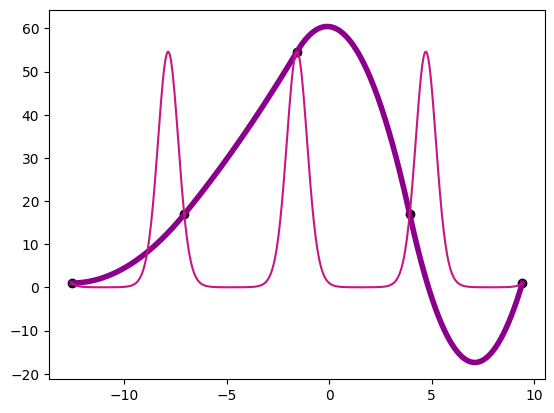

max_err, 		sq_err, 		knots
59.741382739750364, 	942.8394803235116, 	5



Ilość węzłów: 5, funkcja sklejana 2-gi stopień, splajn zaciskany



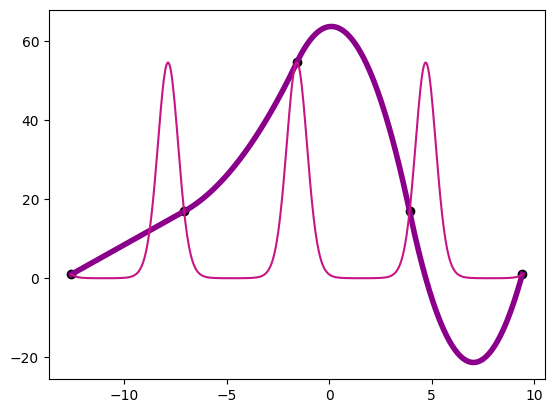

max_err, 		sq_err, 		knots
63.27209493033504, 	997.3640568335709, 	5



Ilość węzłów: 5, funkcja sklejana 3-ci stopień, splajn naturalny



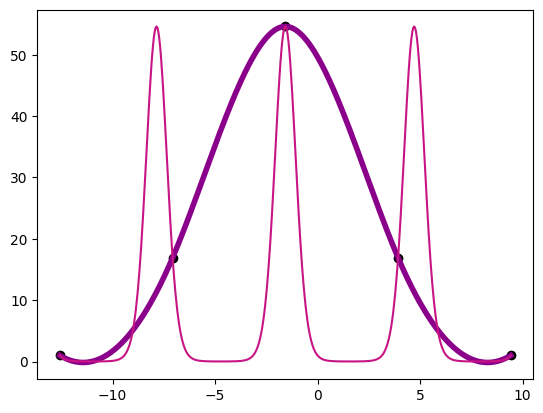

max_err, 		sq_err, 		knots
48.71524512102671, 	734.2822327275223, 	5



Ilość węzłów: 5, funkcja sklejana 3-ci stopień, splajn szescienny



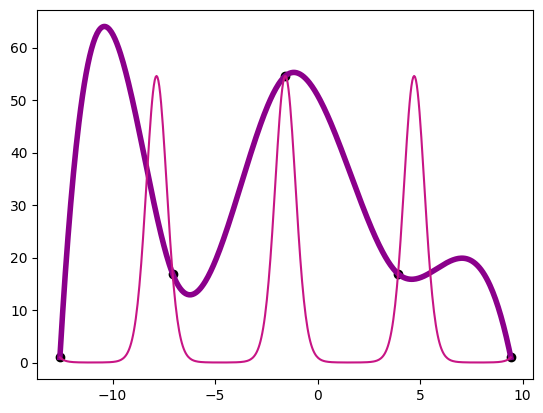

max_err, 		sq_err, 		knots
63.98408029562378, 	1035.332447511521, 	5



Ilość węzłów: 7, funkcja sklejana 2-gi stopień, splajn naturalny



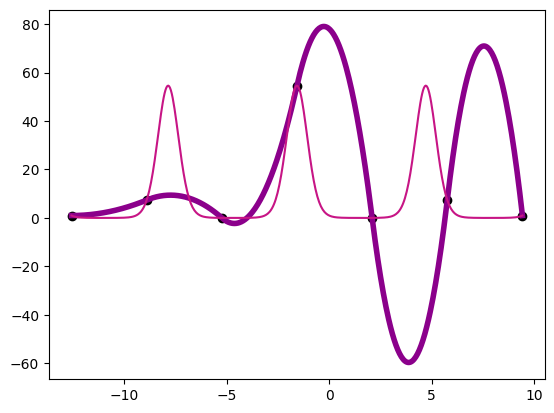

max_err, 		sq_err, 		knots
102.93940846394801, 	1741.4356011004477, 	7



Ilość węzłów: 7, funkcja sklejana 2-gi stopień, splajn zaciskany



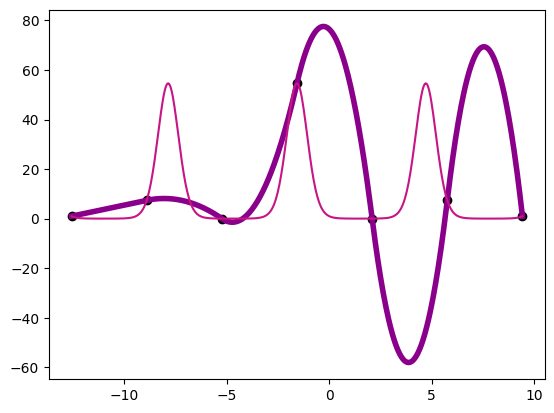

max_err, 		sq_err, 		knots
101.54311023706697, 	1684.7152961626894, 	7



Ilość węzłów: 7, funkcja sklejana 3-ci stopień, splajn naturalny



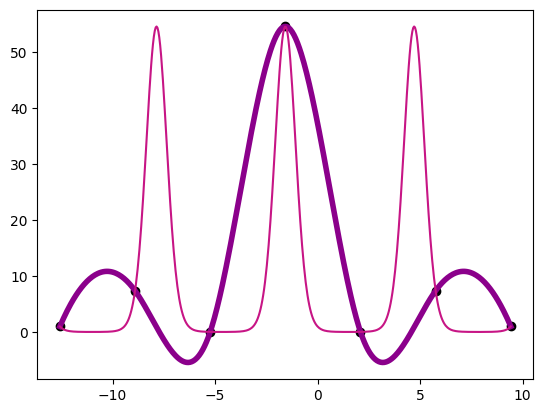

max_err, 		sq_err, 		knots
53.77639975754569, 	465.3677268415017, 	7



Ilość węzłów: 7, funkcja sklejana 3-ci stopień, splajn szescienny



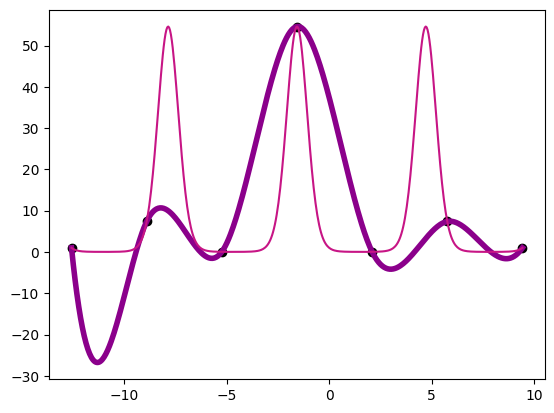

max_err, 		sq_err, 		knots
51.345065573820065, 	424.7301018318437, 	7



Ilość węzłów: 10, funkcja sklejana 2-gi stopień, splajn naturalny



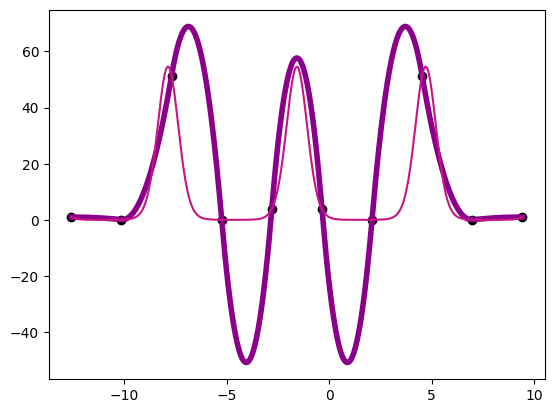

max_err, 		sq_err, 		knots
63.63217029012363, 	786.5889932677146, 	10



Ilość węzłów: 10, funkcja sklejana 2-gi stopień, splajn zaciskany



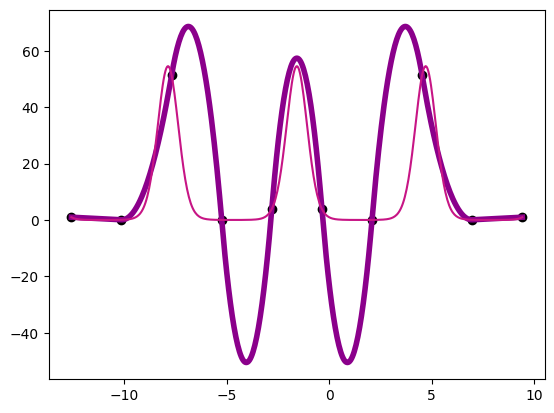

max_err, 		sq_err, 		knots
63.405199840873856, 	780.0241230701774, 	10



Ilość węzłów: 10, funkcja sklejana 3-ci stopień, splajn naturalny



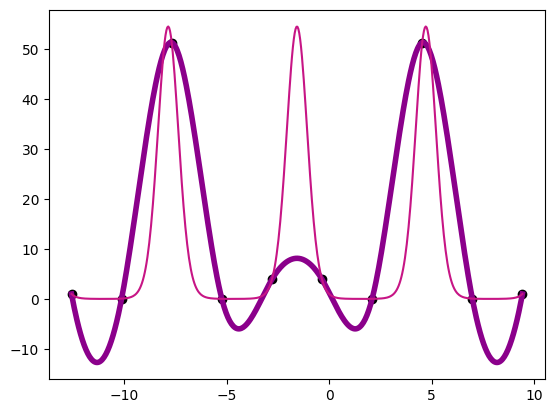

max_err, 		sq_err, 		knots
46.396023268325436, 	250.99033316592497, 	10



Ilość węzłów: 10, funkcja sklejana 3-ci stopień, splajn szescienny



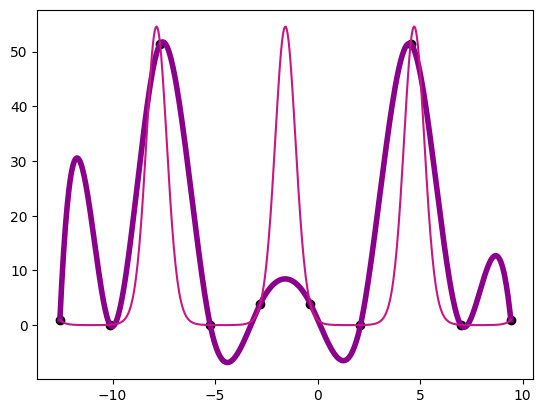

max_err, 		sq_err, 		knots
46.079252234394716, 	269.51975733199214, 	10



Ilość węzłów: 15, funkcja sklejana 2-gi stopień, splajn naturalny



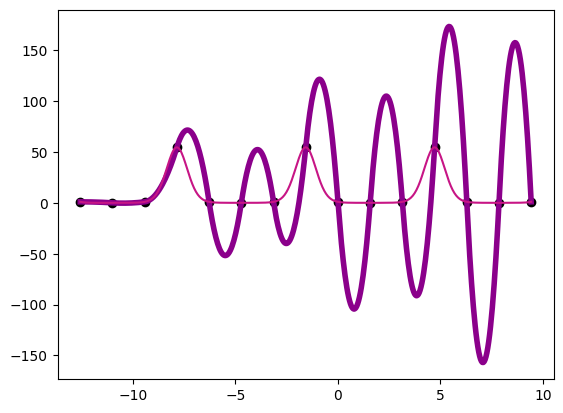

max_err, 		sq_err, 		knots
157.54378923240964, 	4866.209332764189, 	15



Ilość węzłów: 15, funkcja sklejana 2-gi stopień, splajn zaciskany



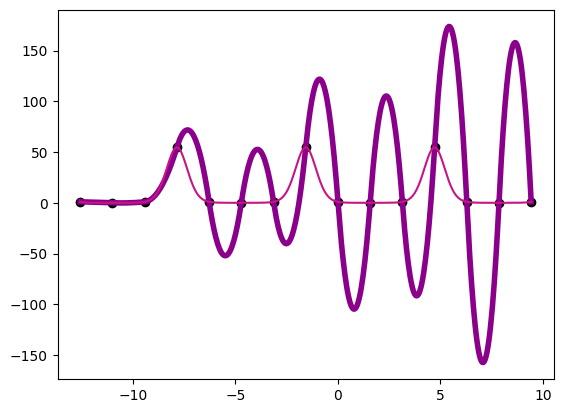

max_err, 		sq_err, 		knots
157.78918568211466, 	4886.732937471899, 	15



Ilość węzłów: 15, funkcja sklejana 3-ci stopień, splajn naturalny



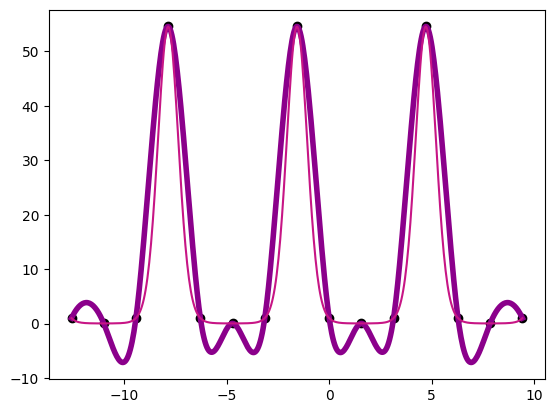

max_err, 		sq_err, 		knots
16.654669573854754, 	55.24740316007898, 	15



Ilość węzłów: 15, funkcja sklejana 3-ci stopień, splajn szescienny



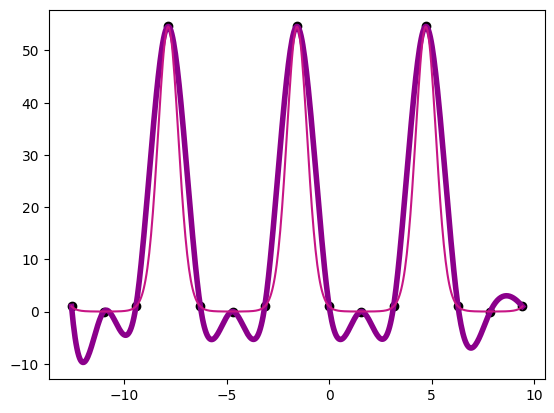

max_err, 		sq_err, 		knots
16.595989256698772, 	55.533344459505635, 	15



Ilość węzłów: 20, funkcja sklejana 2-gi stopień, splajn naturalny



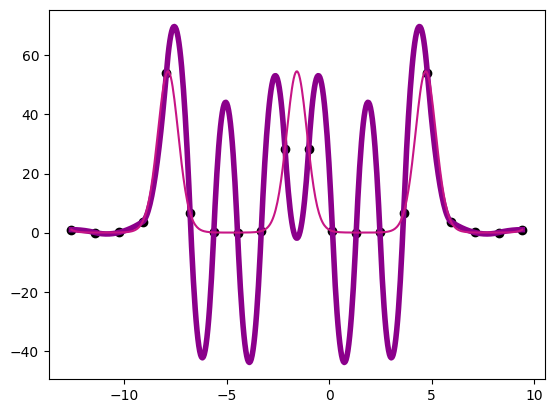

max_err, 		sq_err, 		knots
56.394930447892385, 	589.2111824185591, 	20



Ilość węzłów: 20, funkcja sklejana 2-gi stopień, splajn zaciskany



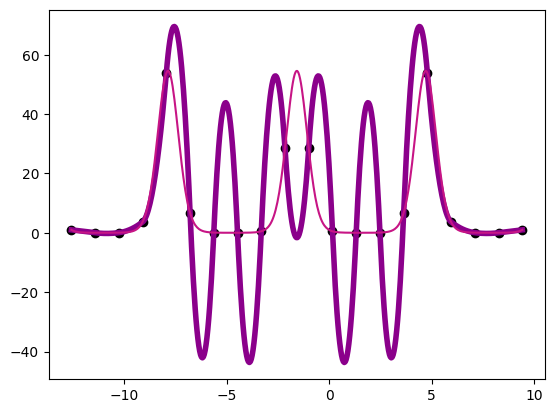

max_err, 		sq_err, 		knots
56.15169685762487, 	582.5262935483703, 	20



Ilość węzłów: 20, funkcja sklejana 3-ci stopień, splajn naturalny



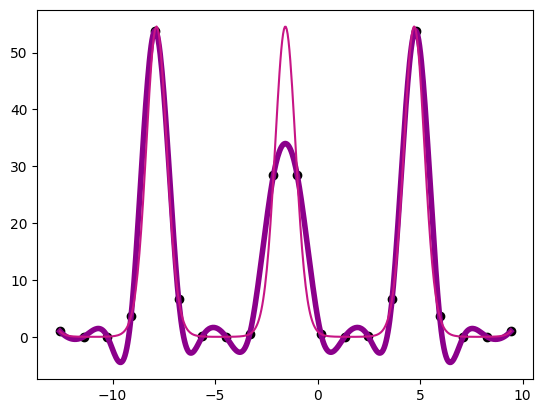

max_err, 		sq_err, 		knots
20.536767297049323, 	23.057170063830423, 	20



Ilość węzłów: 20, funkcja sklejana 3-ci stopień, splajn szescienny



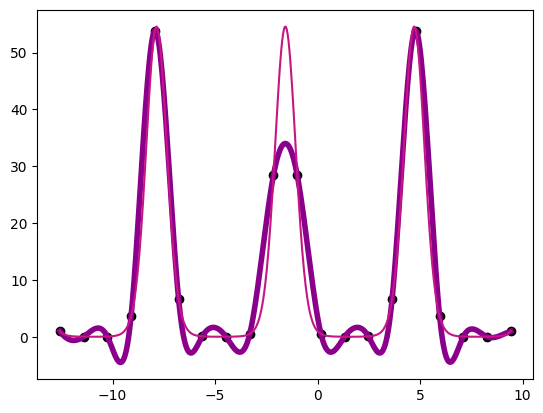

max_err, 		sq_err, 		knots
20.536768992017336, 	23.050593297217166, 	20



Ilość węzłów: 30, funkcja sklejana 2-gi stopień, splajn naturalny



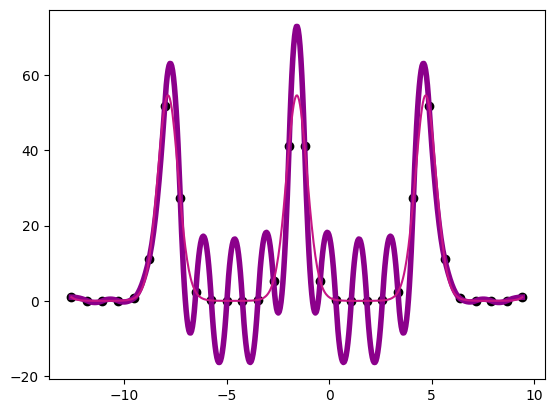

max_err, 		sq_err, 		knots
18.326402043833802, 	84.88156961064186, 	30



Ilość węzłów: 30, funkcja sklejana 2-gi stopień, splajn zaciskany



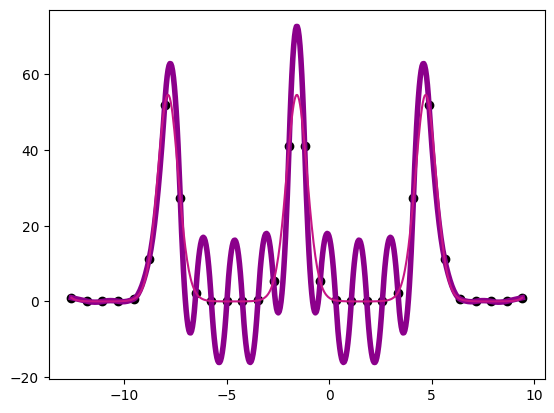

max_err, 		sq_err, 		knots
18.093161701379522, 	82.39606600786739, 	30



Ilość węzłów: 30, funkcja sklejana 3-ci stopień, splajn naturalny



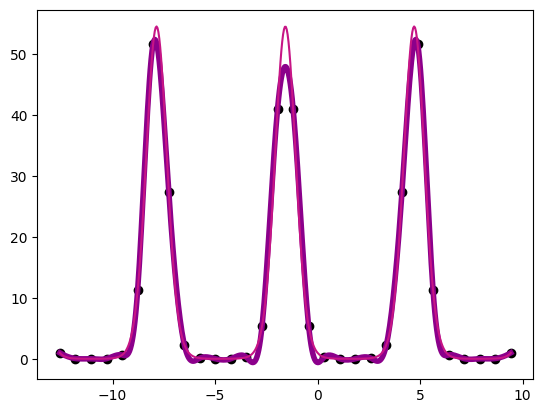

max_err, 		sq_err, 		knots
6.562627282573956, 	2.7971472483823527, 	30



Ilość węzłów: 30, funkcja sklejana 3-ci stopień, splajn szescienny



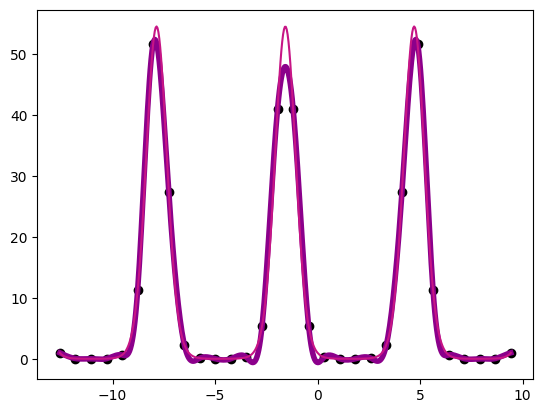

max_err, 		sq_err, 		knots
6.562627280681596, 	2.798746464008382, 	30



Ilość węzłów: 60, funkcja sklejana 2-gi stopień, splajn naturalny



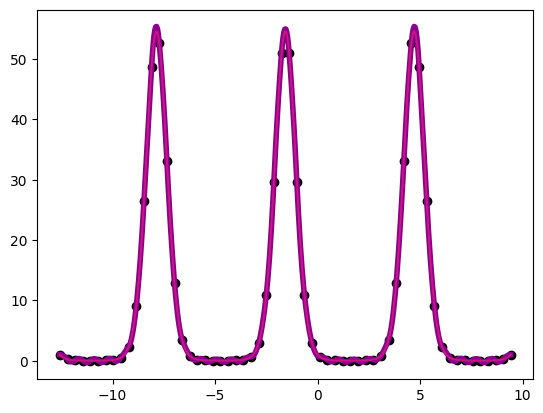

max_err, 		sq_err, 		knots
0.9112288227810694, 	0.0634667061857147, 	60



Ilość węzłów: 60, funkcja sklejana 2-gi stopień, splajn zaciskany



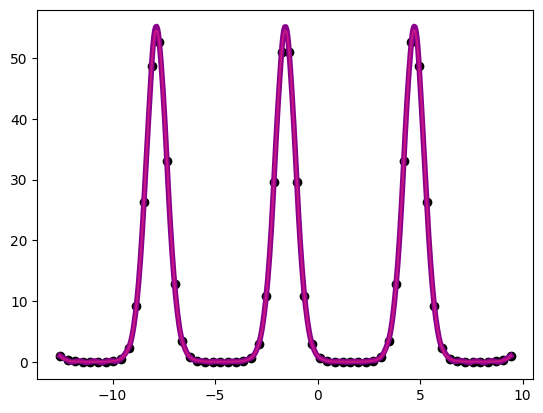

max_err, 		sq_err, 		knots
0.725046846001824, 	0.025730273673759466, 	60



Ilość węzłów: 60, funkcja sklejana 3-ci stopień, splajn naturalny



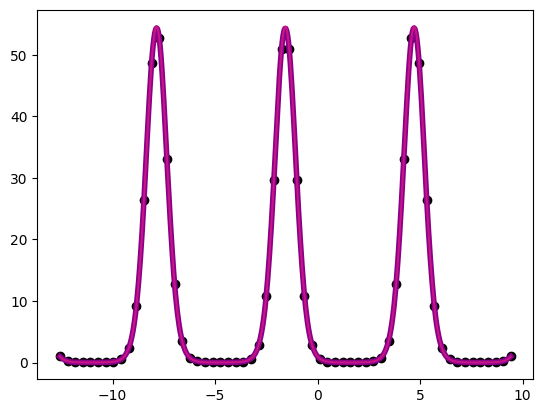

max_err, 		sq_err, 		knots
0.28369077157008604, 	0.0030002251094820884, 	60



Ilość węzłów: 60, funkcja sklejana 3-ci stopień, splajn szescienny



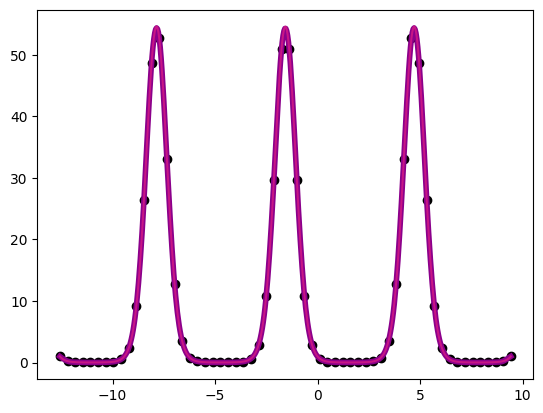

max_err, 		sq_err, 		knots
0.28369077157008604, 	0.0031429855516580426, 	60



Ilość węzłów: 100, funkcja sklejana 2-gi stopień, splajn naturalny



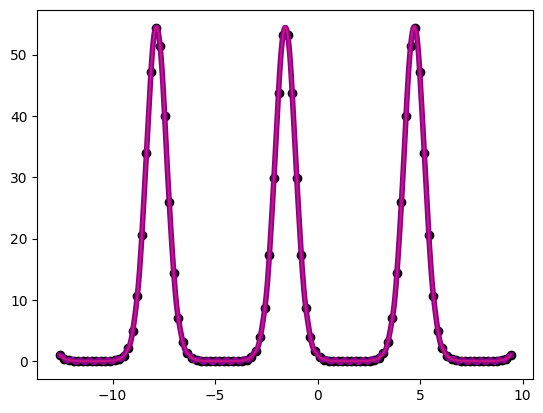

max_err, 		sq_err, 		knots
0.25966306235743275, 	0.023560582912529753, 	100



Ilość węzłów: 100, funkcja sklejana 2-gi stopień, splajn zaciskany



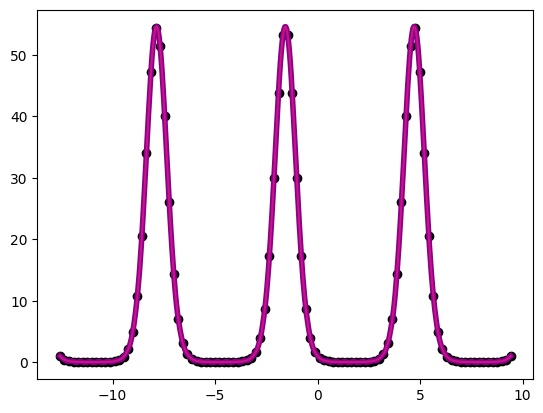

max_err, 		sq_err, 		knots
0.11571471282260148, 	0.002398855474298913, 	100



Ilość węzłów: 100, funkcja sklejana 3-ci stopień, splajn naturalny



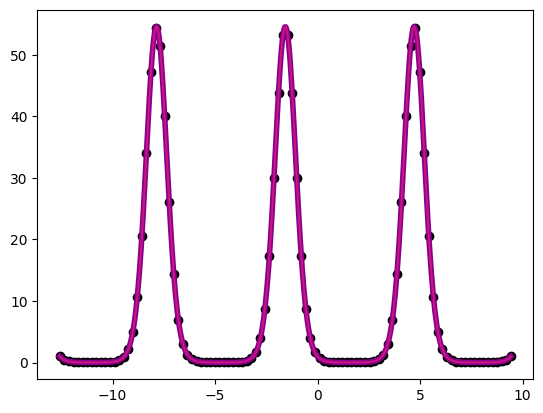

max_err, 		sq_err, 		knots
0.02227207605067605, 	2.1174003734384595e-05, 	100



Ilość węzłów: 100, funkcja sklejana 3-ci stopień, splajn szescienny



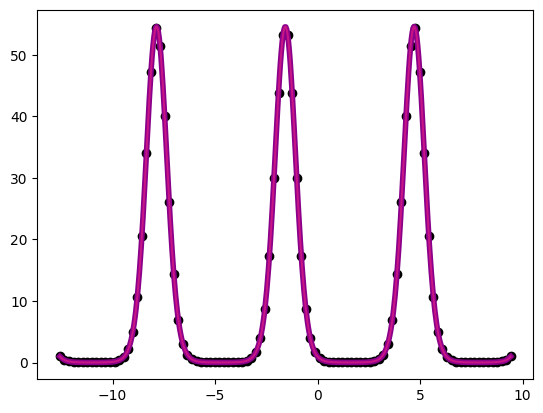

max_err, 		sq_err, 		knots
0.0474671890349867, 	3.5510050538626185e-05, 	100



Ilość węzłów: 150, funkcja sklejana 2-gi stopień, splajn naturalny



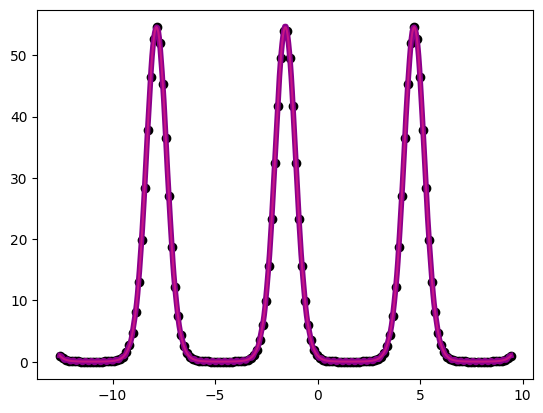

max_err, 		sq_err, 		knots
0.15384292601747518, 	0.011002117606355541, 	150



Ilość węzłów: 150, funkcja sklejana 2-gi stopień, splajn zaciskany



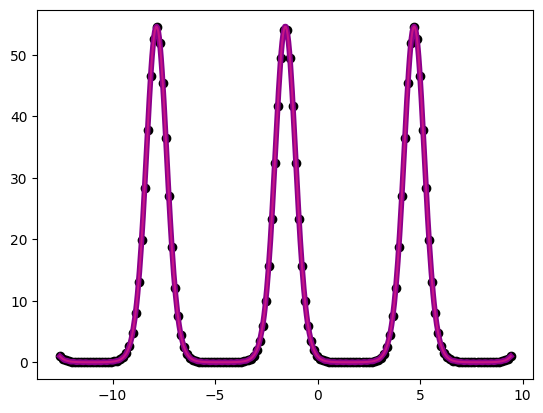

max_err, 		sq_err, 		knots
0.043657152060568194, 	0.0005808143185271808, 	150



Ilość węzłów: 150, funkcja sklejana 3-ci stopień, splajn naturalny



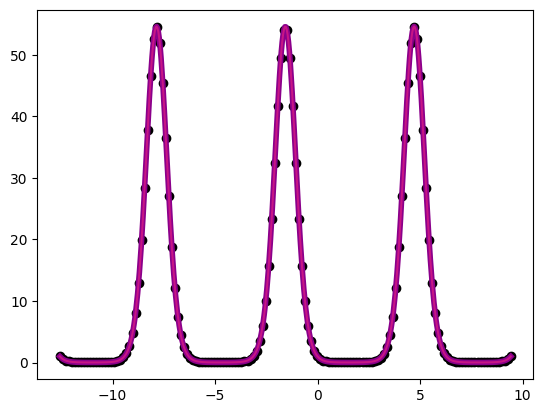

max_err, 		sq_err, 		knots
0.005447850859300329, 	7.255483365223483e-07, 	150



Ilość węzłów: 150, funkcja sklejana 3-ci stopień, splajn szescienny



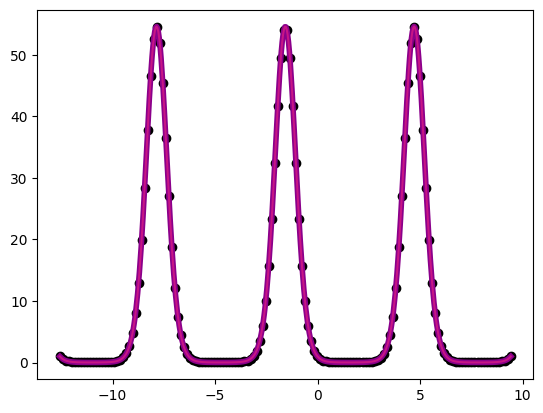

max_err, 		sq_err, 		knots
0.020197196225250513, 	2.717456732142509e-06, 	150



Ilość węzłów: 250, funkcja sklejana 2-gi stopień, splajn naturalny



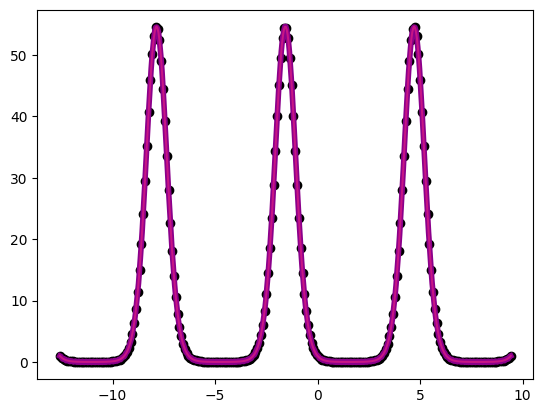

max_err, 		sq_err, 		knots
0.0875452718183517, 	0.004072451137036219, 	250



Ilość węzłów: 250, funkcja sklejana 2-gi stopień, splajn zaciskany



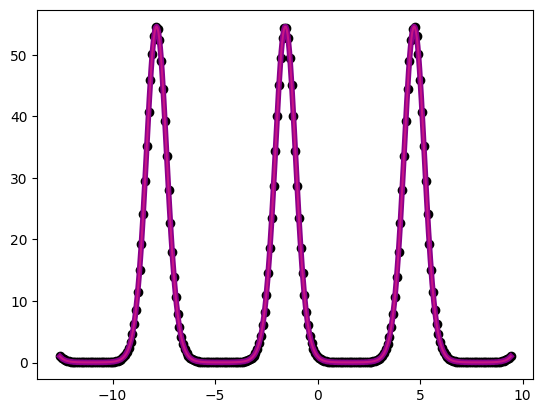

max_err, 		sq_err, 		knots
0.014659948486865915, 	9.274782825023359e-05, 	250



Ilość węzłów: 250, funkcja sklejana 3-ci stopień, splajn naturalny



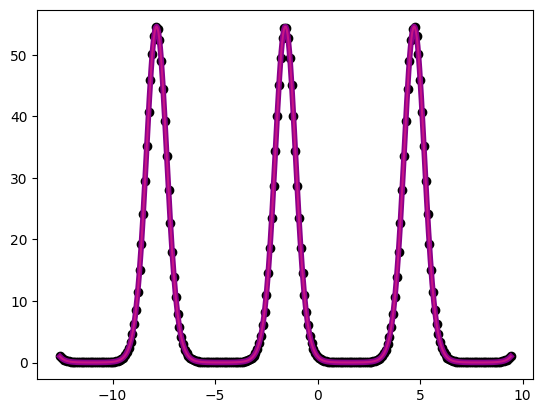

max_err, 		sq_err, 		knots
0.0012608491414469736, 	1.3686447757080288e-08, 	250



Ilość węzłów: 250, funkcja sklejana 3-ci stopień, splajn szescienny



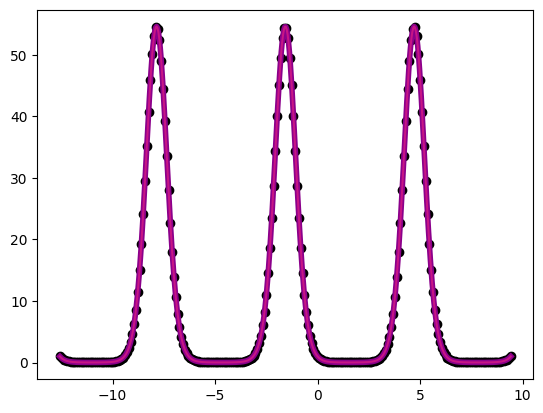

max_err, 		sq_err, 		knots
0.006733448838506462, 	1.5608613170240407e-07, 	250



Ilość węzłów: 400, funkcja sklejana 2-gi stopień, splajn naturalny



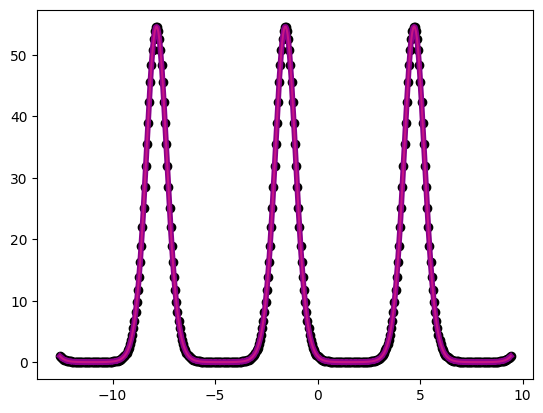

max_err, 		sq_err, 		knots
0.0550255041987846, 	0.001604679983527046, 	400



Ilość węzłów: 400, funkcja sklejana 2-gi stopień, splajn zaciskany



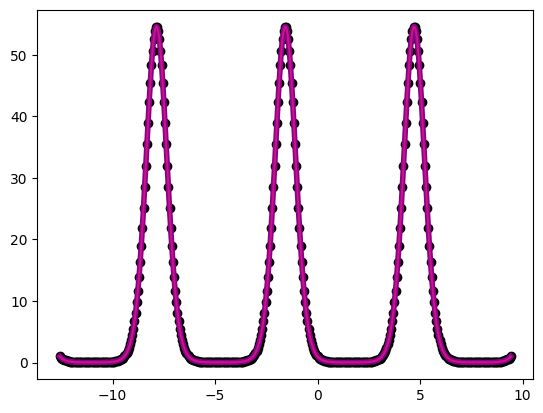

max_err, 		sq_err, 		knots
0.005686211457934576, 	1.5942399662852855e-05, 	400



Ilość węzłów: 400, funkcja sklejana 3-ci stopień, splajn naturalny



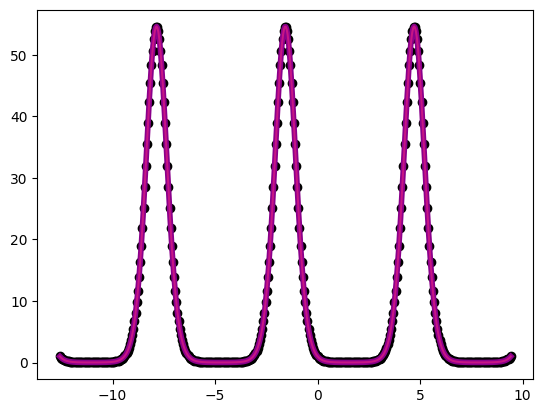

max_err, 		sq_err, 		knots
0.0001369236525170514, 	2.547894155315596e-10, 	400



Ilość węzłów: 400, funkcja sklejana 3-ci stopień, splajn szescienny



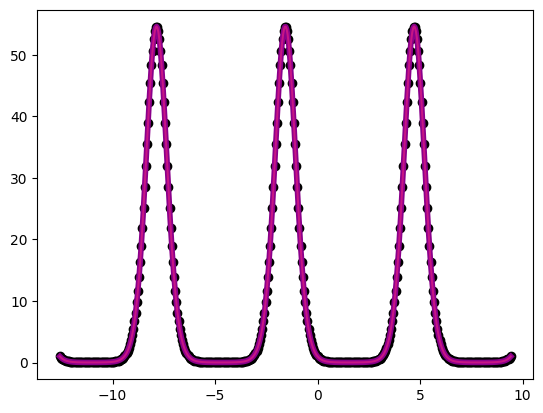

max_err, 		sq_err, 		knots
0.0010529387388988898, 	4.936685979651778e-09, 	400



Ilość węzłów: 1000, funkcja sklejana 2-gi stopień, splajn naturalny



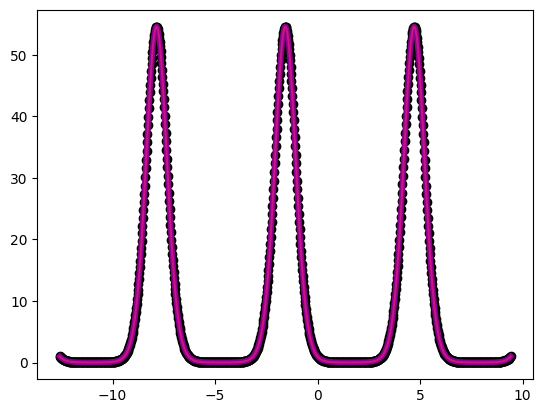

max_err, 		sq_err, 		knots
0.02200495545029213, 	0.00025761329994423136, 	1000



Ilość węzłów: 1000, funkcja sklejana 2-gi stopień, splajn zaciskany



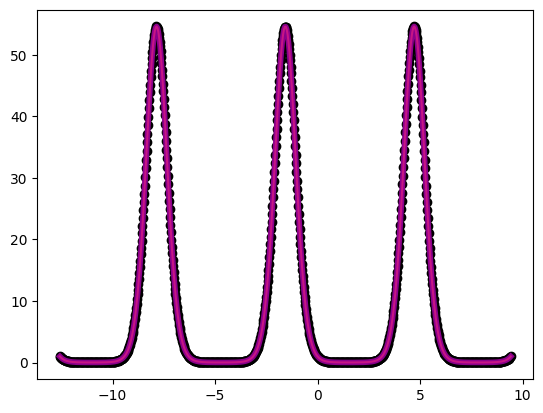

max_err, 		sq_err, 		knots
0.0009348345331687824, 	4.6018905660017553e-07, 	1000



Ilość węzłów: 1000, funkcja sklejana 3-ci stopień, splajn naturalny



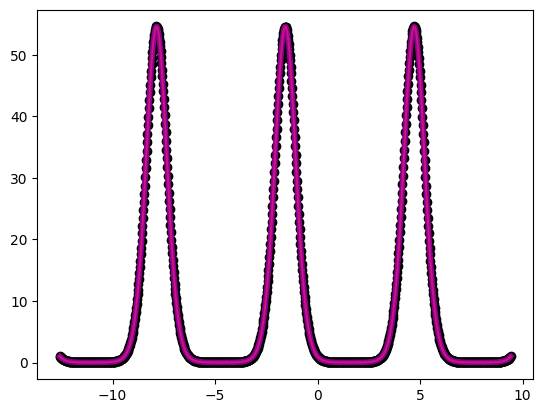

max_err, 		sq_err, 		knots
1.7312329561036677e-06, 	1.1102314026655309e-13, 	1000



Ilość węzłów: 1000, funkcja sklejana 3-ci stopień, splajn szescienny



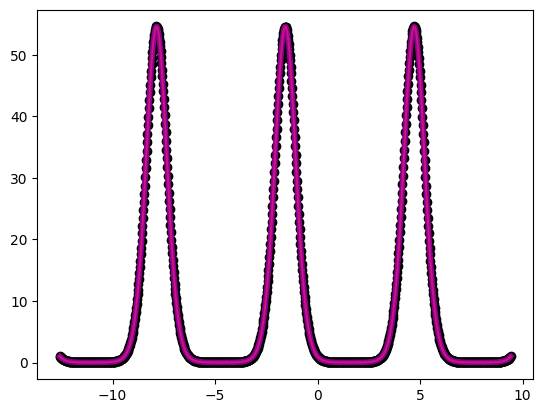

max_err, 		sq_err, 		knots
1.7312329561036677e-06, 	1.1144509337409676e-13, 	1000


In [42]:
start = -4 * np.pi
end = 3 * np.pi

knots_numbers = [5, 7, 10, 15, 20, 30, 60, 100, 150, 250, 400, 1000]

for knots_nb in knots_numbers:
    print(f"\n\n\nIlość węzłów: {knots_nb}, funkcja sklejana 2-gi stopień, splajn naturalny\n")
    draw_plot(start, end, knots_nb, given_function, even_distribution, quadratic_spline, 1, True)
    
    print(f"\n\n\nIlość węzłów: {knots_nb}, funkcja sklejana 2-gi stopień, splajn zaciskany\n")
    draw_plot(start, end, knots_nb, given_function, even_distribution, quadratic_spline, 2, True)
    
    print(f"\n\n\nIlość węzłów: {knots_nb}, funkcja sklejana 3-ci stopień, splajn naturalny\n")
    draw_plot(start, end, knots_nb, given_function, even_distribution, cubic_spline, 1, True)
    
    print(f"\n\n\nIlość węzłów: {knots_nb}, funkcja sklejana 3-ci stopień, splajn szescienny\n")
    draw_plot(start, end, knots_nb, given_function, even_distribution, cubic_spline, 2, True)